In [1]:
#load packages and data files
require("MASS")
require("robustlmm")
library(lme4)
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=8)
library(sjPlot)
library(RColorBrewer)
library(stargazer)
library("tidyr")
library(showtext)
require("robustlmm")
font_add("DejaVu Sans", "~/Library/Fonts/DejaVuSans.ttf")
font_add("Arial", "/Library/Fonts/Arial Unicode.ttf")# Use the actual file path
showtext_auto()
options(warn=-1)

setwd("/Users/ilima/Google Drive/Projects/Development of planning/4inarow_fitting_data/")
df_age_cat <- read.csv('df_age_cat.csv')
df_age_cat$ageGroup[df_age_cat$ageBins == "(18, 26]"] <- 3
df_age_cat$ageGroup[df_age_cat$ageBins == "(12, 18]"] <- 2
df_age_cat$ageGroup[df_age_cat$ageBins == "(7, 12]"] <- 1
df_age_cat$f_ageGroup <- as.factor(df_age_cat$ageGroup)

df_age_medcat <- read.csv('df_age_medcat.csv')
df_age_maxcat <- read.csv('df_age_maxcat.csv')
df_duration <- read.csv('gameDurations.csv')
df_rt <- read.csv('df_rt.csv')
age <- read.csv('demog_12_9.csv')
setwd("/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Analysis notebooks/data")
meanMetrics <- read.csv('meanMetrics.csv')
metrics <- read.csv('metrics.csv', header=TRUE)
#metrics <- read.csv('metrics_noScaling.csv', header=TRUE)
#meanMetrics <- aggregate(metrics[, 2:14], list(metrics$StudyID), mean)
meanMetrics$StudyID <- meanMetrics$Group.1

metrics$gender <- ifelse(metrics$Gender=='F', 1, ifelse(metrics$Gender=='M', 0, 0))
metrics$s_ExactAge <- (scale(metrics$ExactAge))


df_rt$ageGroup[df_rt$ageBins == "(18, 26]"] <- 3
df_rt$ageGroup[df_rt$ageBins == "(12, 18]"] <- 2
df_rt$ageGroup[df_rt$ageBins == "(7, 12]"] <- 1
df_rt$f_ageGroup <- as.factor(df_rt$ageGroup)
tail(df_rt)

Loading required package: MASS
Warning message:
“package ‘MASS’ was built under R version 3.5.2”Loading required package: robustlmm
Warning message:
“package ‘robustlmm’ was built under R version 3.5.2”Loading required package: lme4
Loading required package: Matrix

Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 

Warning message:
“package ‘tidyr’ was built under R version 3.5.2”
Attaching package: ‘tidyr’

The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack

Warning message:
“package ‘showtext’ was built under R version 3.5.2”Loading required package: sysfonts
Loading required package: showtextdb


,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBins,User,GameNr,Category,Level,MoveNr,RT,Result,ageGroup,f_ageGroup
11137,856,4/13/10,M,10.6493,10,12/3/20,"(7, 12]",856:R_3EEYoLyNN9SpuuT,33,17,166,5,3.099,opponent win,1,1
11138,856,4/13/10,M,10.6493,10,12/3/20,"(7, 12]",856:R_3EEYoLyNN9SpuuT,34,16,150,1,2.429,win,1,1
11139,856,4/13/10,M,10.6493,10,12/3/20,"(7, 12]",856:R_3EEYoLyNN9SpuuT,34,16,150,2,1.104,win,1,1
11140,856,4/13/10,M,10.6493,10,12/3/20,"(7, 12]",856:R_3EEYoLyNN9SpuuT,34,16,150,3,2.160,win,1,1
11141,856,4/13/10,M,10.6493,10,12/3/20,"(7, 12]",856:R_3EEYoLyNN9SpuuT,34,16,150,4,1.061,win,1,1
11142,832,10/25/12,M,8.1233,8,12/7/20,"(7, 12]",,NA,NA,NA,NA,NA,,1,1


In [2]:
head(meanMetrics)

fold,planningDepth,featureDropRate,heuristicQuality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue
3,6.133230,0.3370140,0.4315325,227,17.4904,17,1,15
3,7.249400,0.3057720,0.6246183,179,15.0055,15,1,15
3,1.835382,0.3623840,0.4482810,179,12.7260,12,0,10
3,3.590356,0.1968608,0.4794924,109,15.9315,15,1,15
3,5.059394,0.2312880,0.5969120,-9,14.4055,14,1,15
3,3.963848,0.2560160,0.5818686,129,14.2712,14,1,15


In [41]:
df_moveMax <- aggregate(MoveNr ~StudyID+GameNr +FlooredAge +ageGroup, data=df_rt, max, na.rm=TRUE)
df_moveMax$f_agegroup <- as.factor(df_moveMax$ageGroup)
head(df_moveMax)
min(df_moveMax$MoveNr)

df_moveMax2 <- aggregate(MoveNr ~StudyID + FlooredAge, data=df_moveMax, sum, na.rm=TRUE)
head(df_moveMax2)
"average number of decisions ="
mean(df_moveMax2$MoveNr)
"SD ="
sd(df_moveMax2$MoveNr)
cor(df_moveMax2$MoveNr, df_moveMax2$FlooredAge, method = c("spearman"))

StudyID,GameNr,FlooredAge,ageGroup,MoveNr,f_agegroup
152,0,8,1,4,1
152,1,8,1,7,1
152,2,8,1,5,1
152,3,8,1,5,1
152,4,8,1,4,1
152,5,8,1,4,1


[1] 3

StudyID,FlooredAge,MoveNr
152,8,209
194,9,170
200,9,227
139,10,358
156,10,206
179,10,237


[1] "average number of decisions ="

[1] 230.9535

[1] "SD ="

[1] 35.41318

[1] 0.03896307

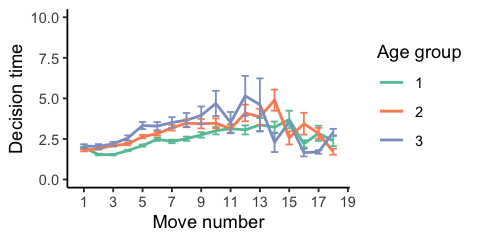

In [42]:

options(repr.plot.width=4, repr.plot.height=2)
p <- ggplot(df_rt, aes(x = MoveNr, y = RT, color = f_ageGroup, fill = f_ageGroup)) + 
  stat_summary(fun.y=mean, geom="line", size =0.8) +
  stat_summary(fun.data=mean_se, geom="errorbar", width = 0.5) + 
  labs(x = "Move number", y = "Decision time", color = "Age group") +
  theme_classic() +
  ylim(0,15)+
  coord_cartesian( ylim = c(0, 10))+
  scale_x_continuous(breaks=seq(1,37,2))+
 scale_colour_manual(values = c("#66c2a5", "#fc8d62", "#8da0cb"))

p

# Relation age and metrics

## Relation between age and elo

In [43]:
head(metrics)

subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue,gender,s_ExactAge
101:R_31SM3mwQvAhBwar,1,6.67758,0.37914,0.4459566,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15,1,0.3099977
101:R_31SM3mwQvAhBwar,2,5.17404,0.40756,0.4295637,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15,1,0.3099977
101:R_31SM3mwQvAhBwar,3,6.41074,0.20175,0.4282075,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15,1,0.3099977
101:R_31SM3mwQvAhBwar,4,6.03305,0.25907,0.4370336,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15,1,0.3099977
101:R_31SM3mwQvAhBwar,5,6.37074,0.43755,0.4169013,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15,1,0.3099977
102:R_vdABJ1XvXNriwff,1,9.34128,0.13684,0.6275961,179,102,11/12/05,F,15.0055,15,11/10/20,"(12, 17]",1,15,1,-0.1785209


In [3]:
meanMetrics$s_ExactAge <- scale(meanMetrics$ExactAge)
lin_elo_model <- lm(elo ~ s_ExactAge, data = meanMetrics)
quad_elo_model <- lm(elo ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)
# check which is best
anova(lin_elo_model, quad_elo_model)

#answer: it's quadratic

# is there a linear or quadtratic effect of age on PD?
tab_model(quad_elo_model)
#answer: yes, both

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
155,2567164,NA,NA,NA,NA
154,2456599,1,110565.4,6.931155,0.009333822


## Relation between age and planning depth

In [16]:
lin_pd_model <- lm(planningDepth ~ s_ExactAge, data = meanMetrics)
quad_pd_model <- lm(planningDepth ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)
log_pd_model <- lm(planningDepth ~ scale(log(ExactAge)), data = meanMetrics)

# check which is best
anova(lin_pd_model, quad_pd_model)

#answer: it's linear

# is there a linear or quadtratic effect of age on PD?
tab_model(quad_pd_model)
#answer: yes, only linear

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
155,1094.147,NA,NA,NA,NA
154,1091.613,1,2.534652,0.3575776,0.550733


## Relation between age and heuristic quality in mean metrics

In [4]:
meanMetrics$s_ExactAge <- scale(meanMetrics$ExactAge)

lin_hq_model <- lm(heuristicQuality ~ s_ExactAge, data = meanMetrics)
quad_hq_model <- lm(heuristicQuality ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)
log_hq_model <- lm(heuristicQuality ~ scale(log(ExactAge)), data = meanMetrics)

#lin_gen_hq_model <- lm(heuristicQuality ~ gender + s_ExactAge, data = meanMetrics)
#quad_gen_hq_model <- lm(heuristicQuality ~ gender + poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)

# check which is best
anova(lin_hq_model, quad_hq_model)

#answer: it's quad_hq_model

# is there a linear or quadtratic effect of age on heuristic quality?
tab_model(quad_hq_model)
#answer: yes, both

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
155,2.152624,NA,NA,NA,NA
154,2.049656,1,0.102968,7.736457,0.006088118


## Relation between age and feature drop 

In [18]:
lin_fd_model <- lm(featureDropRate ~ s_ExactAge, data = meanMetrics)
quad_fd_model <- lm(featureDropRate ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)
log_fd_model <- lm(featureDropRate ~ scale(log(ExactAge)), data = meanMetrics)

# check which is best
anova(lin_fd_model, quad_fd_model)

#answer: it's linear

# is there a linear or quadtratic effect of age on FD?
tab_model(quad_fd_model)
#answer: no

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
155,2.371120,NA,NA,NA,NA
154,2.357696,1,0.01342348,0.876795,0.3505471


# Mixed models for relation between age and metrics

## Mixed effects models Age and planning depth

In [45]:
metrics$s_planningDepth <- scale(metrics$planningDepth)
metrics$s_featureDropRate <- scale(metrics$featureDropRate)
metrics$s_heuristicQuality <- scale(metrics$heuristicQuality)
metrics$s_elo <- scale(metrics$elo)
metrics$s_ExactAge <- scale(metrics$ExactAge)

pd_age <- lmer(planningDepth ~ s_ExactAge + (1|fold), data=metrics)
pd_agequad <- lmer(planningDepth ~ poly(s_ExactAge, degree = 2, raw = TRUE) + (1|fold), data=metrics)
pd_agegen <- lmer(planningDepth ~ s_ExactAge * as.factor(gender) + (1|fold), data=metrics)
pd_agequadgen <- lmer(planningDepth ~ poly(s_ExactAge, degree = 2, raw = TRUE) * as.factor(gender) + (1|fold), data=metrics)

anova(pd_age, pd_agequad) #linear is best. Adding gender improves the model. Esp for quadratic age * 
#summary(pd_age)
tab_model(pd_agequad)


boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
pd_age,4,4224.168,4242.831,-2108.084,4216.168,NA,NA,NA
pd_agequad,5,4225.161,4248.489,-2107.580,4215.161,1.007123,1,0.315593


## Mixed effects model age and HQ

In [20]:
hq_age <- lmer(heuristicQuality ~ s_ExactAge + (1|fold), data=metrics)
hq_agequad <- lmer(heuristicQuality ~ poly(s_ExactAge, degree = 2, raw = TRUE) + (1|fold), data=metrics)
hq_loggage <- lmer(heuristicQuality ~ scale(log(ExactAge)) + (1|fold), data=metrics)
hq_agegen <- lmer(heuristicQuality ~ s_ExactAge * as.factor(gender) + (1|fold), data=metrics)
hq_agequadgen <- lmer(heuristicQuality ~ poly(s_ExactAge, degree = 2, raw = TRUE)* as.factor(gender) + (1|fold), data=metrics)

anova(hq_age, hq_agequad) #linear is better, adding gender doesn't improve model
tab_model(hq_age)

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
hq_age,4,-1066.411,-1047.92,537.2055,-1074.411,NA,NA,NA
hq_agequad,5,-1089.643,-1066.53,549.8216,-1099.643,25.23209,1,5.08294e-07


## Mixed effects model Age and feature drop 

In [21]:
fd_age <- lmer(featureDropRate ~ s_ExactAge + (1|fold), data=metrics)
fd_agequad <- lmer(featureDropRate ~ poly(s_ExactAge, degree = 2, raw = TRUE) + (1|fold), data=metrics)
fd_logage <- lmer(featureDropRate ~ scale(log(ExactAge)) + (1|fold), data=metrics)
fd_agegen <- lmer(featureDropRate ~ s_ExactAge * as.factor(gender) + (1|fold), data=metrics)
fd_agequadgen <- lmer(featureDropRate ~ poly(s_ExactAge, degree = 2, raw = TRUE) * as.factor(gender) + (1|fold), data=metrics)

anova(fd_age, fd_agequad) #linear, adding gender does not improve models
tab_model(fd_age)

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
fd_age,4,-641.0659,-622.5750,324.5330,-649.0659,NA,NA,NA
fd_agequad,5,-644.2788,-621.1651,327.1394,-654.2788,5.212902,1,0.02241989


# Relation between Elo and the mean model derived metrics 

## Regular ELO regression model on mean metrics

In [9]:
#shows interaction between age and planning depth and main effects for other metrics
elo_metrics <- lm(elo ~ s_ExactAge * (scale(planningDepth) + scale(heuristicQuality) + scale(featureDropRate)), data=meanMetrics)
tab_model(elo_metrics)

,fold,planningDepth,featureDropRate,heuristicQuality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue,s_ExactAge
43,3,12.206460,0.0000386,0.11452235,-483,12.2603,12,0,10,-0.7163787
64,3,16.263678,0.0000736,0.05989026,-198,17.0712,17,1,15,0.2270038
24,3,2.031765,0.3375120,0.53586132,-178,11.5205,11,0,10,-0.8614481
117,3,6.146624,0.1044346,0.20526471,-125,24.4247,24,2,21,1.6689717


,fold,planningDepth,featureDropRate,heuristicQuality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue,s_ExactAge,d1,r
8,3,0.6936697,0.06324556,0.28746419,-194,10.0219,10,0,10,-1.1553126,0.08542550,-1.935237
43,3,12.2064600,0.00003860,0.11452235,-483,12.2603,12,0,10,-0.7163787,0.25739201,-4.080826
54,3,3.3557181,0.00001240,0.04659144,115,17.0904,17,1,15,0.2307688,0.12538592,2.007681
64,3,16.2636780,0.00007360,0.05989026,-198,17.0712,17,1,15,0.2270038,0.42800189,-2.949985
117,3,6.1466240,0.10443459,0.20526471,-125,24.4247,24,2,21,1.6689717,0.35696377,-2.438605
128,3,3.9926552,0.56987000,0.51368323,-139,25.6575,25,2,21,1.9107148,0.08847088,-2.016494
138,3,5.9914280,0.63044800,0.39453746,206,22.6438,22,2,21,1.3197501,0.08725567,1.734177


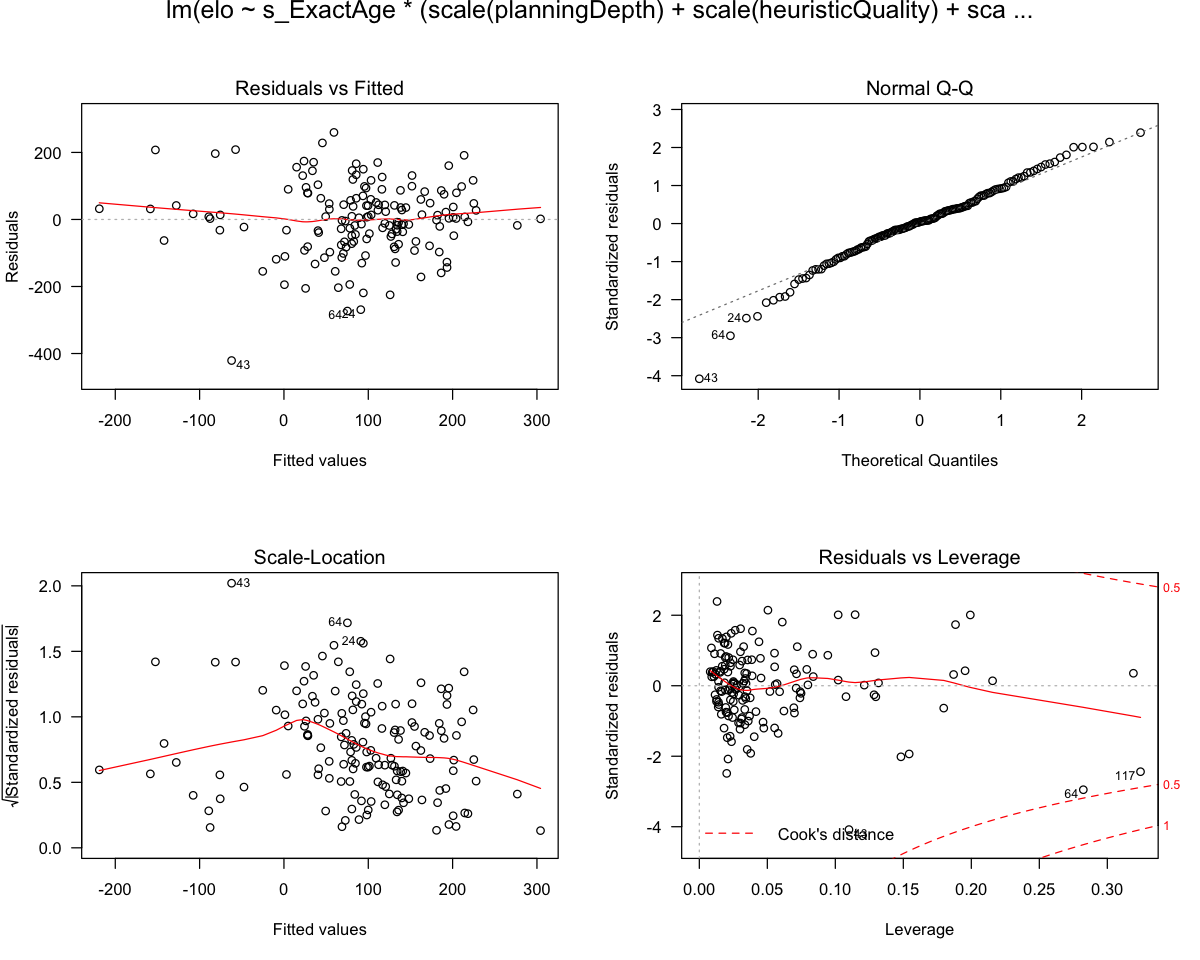

In [20]:
opar <- par(mfrow = c(2,2), oma = c(0, 0, 1.1, 0))
plot(elo_metrics, las = 1)
par(opar)
meanMetrics[c(43, 64, 24, 117), ]

d1 <- cooks.distance(elo_metrics)
r <- stdres(elo_metrics)
a <- cbind(meanMetrics, d1, r)
a[d1 > 4/51, ]

## Robust ELO regression model on mean metrics

In [22]:
elo_metrics_robust <- rlm(elo ~ s_ExactAge * (scale(planningDepth) + scale(heuristicQuality) + scale(featureDropRate)), data=meanMetrics, psi = psi.bisquare)
elo_metricsquad_robust <- rlm(elo ~ poly(s_ExactAge, degree = 2, raw = TRUE) * (scale(planningDepth) + scale(heuristicQuality) + scale(featureDropRate)), data=meanMetrics, psi = psi.bisquare)

anova(elo_metrics_robust, elo_metricsquad_robust)
summary(elo_metrics_robust)
tab_model(elo_metrics_robust)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
NA,2201843,NA,NA,NA,NA
NA,2314788,NA,-112944.9,NA,NA



Call: rlm(formula = elo ~ s_ExactAge * (scale(planningDepth) + scale(heuristicQuality) + 
    scale(featureDropRate)), data = meanMetrics, psi = psi.bisquare)
Residuals:
     Min       1Q   Median       3Q      Max 
-601.428  -57.058   -3.849   53.940  251.848 

Coefficients:
                                   Value    Std. Error t value 
(Intercept)                        108.6293   8.3388    13.0269
s_ExactAge                          34.4861   8.4365     4.0877
scale(planningDepth)                50.1711   9.0243     5.5596
scale(heuristicQuality)             26.0114   9.2189     2.8215
scale(featureDropRate)             -37.9740   8.3877    -4.5274
s_ExactAge:scale(planningDepth)     35.3679   9.0248     3.9190
s_ExactAge:scale(heuristicQuality) -39.8532   8.8339    -4.5114
s_ExactAge:scale(featureDropRate)   -4.2858   8.1257    -0.5274

Residual standard error: 82.92 on 149 degrees of freedom

In [8]:
meanMetrics_age1 <- meanMetrics[!(meanMetrics$ageBinNr=="1" | meanMetrics$ageBinNr=="2"),]
meanMetrics_age2 <- meanMetrics[!(meanMetrics$ageBinNr=="0" | meanMetrics$ageBinNr=="2"),]
meanMetrics_age3 <- meanMetrics[!(meanMetrics$ageBinNr=="0" | meanMetrics$ageBinNr=="1"),]

Robustmodel_followup <- function(df) {
    df$s_planningDepth <- scale(df$planningDepth)
    df$s_featureDropRate <- scale(df$featureDropRate)
    df$s_heuristicQuality <- scale(df$heuristicQuality)
    df$s_ExactAge <- scale(df$ExactAge)

    Elo_model_post_robust <- rlm(elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality, data=df)
    table <- tab_model(Elo_model_post_robust)
    return(table)
    }

Robustmodel_followup(meanMetrics_age1)
Robustmodel_followup(meanMetrics_age2)
Robustmodel_followup(meanMetrics_age3)

## Mixed effects model shows relation between Elo and the model derived metrics 

## Robust mixed effects model

In [46]:
#shows interaction between age and planning depth, and age and HQ. Main effects for pd, hq, and age but not fdr
Elo_modelfold_robust <- summary(rlmer(elo ~ s_ExactAge * (scale(planningDepth) + scale(featureDropRate) + scale(heuristicQuality)) +(1|fold), metrics))
#higher efficiency doesn't matter
rfm2 <- update(Elo_modelfold_robust, rho.sigma.e = psi2propII(smoothPsi, k = 2.28), rho.sigma.b = psi2propII(smoothPsi, k = 2.28))
compare(Elo_modelfold_robust, rfm2, show.rho.functions = FALSE)
plot(Elo_modelfold_robust)
tab_model(Elo_modelfold_robust)

boundary (singular) fit: see ?isSingular


In [27]:
head(metrics)

subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,⋯,TaskDate,ageBin,ageBinNr,ageBinValue,gender,s_ExactAge,s_planningDepth,s_featureDropRate,s_heuristicQuality,s_elo
101:R_31SM3mwQvAhBwar,1,6.67758,0.37914,0.4459566,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.8322211,0.3596428,-0.4044302,1.0143470
101:R_31SM3mwQvAhBwar,2,5.17404,0.40756,0.4295637,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.2920569,0.5403491,-0.5389408,1.0143470
101:R_31SM3mwQvAhBwar,3,6.41074,0.20175,0.4282075,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.7363557,-0.7682777,-0.5500687,1.0143470
101:R_31SM3mwQvAhBwar,4,6.03305,0.25907,0.4370336,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.6006662,-0.4038129,-0.4776468,1.0143470
101:R_31SM3mwQvAhBwar,5,6.37074,0.43755,0.4169013,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.7219853,0.7310382,-0.6428401,1.0143470
102:R_vdABJ1XvXNriwff,1,9.34128,0.13684,0.6275961,179,102,11/12/05,F,15.0055,⋯,11/10/20,"(12, 17]",1,15,1,-0.1929323,1.7891862,-1.1810028,1.0859892,0.6374983


In [162]:
#Using folds as random effect shows interactions between age and planning depth and age and HQ and main effect fdr
Elo_modelfold <- lmer(elo ~ s_ExactAge * (scale(planningDepth) + scale(featureDropRate) + scale(heuristicQuality)) +(1|fold), data=metrics)
Elo_modelfold_quad <- lmer(elo ~ poly(s_ExactAge, degree = 2, raw = TRUE) * (scale(planningDepth) + scale(featureDropRate) + scale(heuristicQuality)) +(1|fold), data=metrics)

Elo_modelfoldgen <- lmer(elo ~ s_ExactAge * (scale(planningDepth) + scale(featureDropRate) + scale(heuristicQuality)) + as.factor(gender) +(1|fold), data=metrics)

anova(Elo_modelfold, Elo_modelfold_quad) # adding gender does not improve the model
summary(Elo_modelfold)
tab_model(Elo_modelfold_quad)


boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
Elo_modelfold,10,9027.869,9073.963,-4503.935,9007.869,NA,NA,NA
Elo_modelfold_quad,14,9022.546,9087.077,-4497.273,8994.546,13.32314,4,0.00980019


Linear mixed model fit by REML ['lmerMod']
Formula: elo ~ s_ExactAge * (scale(planningDepth) + scale(featureDropRate) +  
    scale(heuristicQuality)) + (1 | fold)
   Data: metrics

REML criterion at convergence: 8971.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3653 -0.6083  0.0503  0.6826  2.9173 

Random effects:
 Groups   Name        Variance Std.Dev.
 fold     (Intercept)     0      0.0   
 Residual             11081    105.3   
Number of obs: 742, groups:  fold, 5

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                          99.670      4.090  24.367
s_ExactAge                           28.082      4.125   6.807
scale(planningDepth)                 34.185      4.055   8.430
scale(featureDropRate)              -25.329      3.888  -6.515
scale(heuristicQuality)              23.010      4.291   5.363
s_ExactAge:scale(planningDepth)       7.152      3.936   1.817
s_ExactAge:scale(featureDropRate)    -3.809    

### follow-up on significant interaction effects

In [126]:
# re-run the mixed model per age group
## first subset the dataframe
metrics_age1 <- metrics[!(metrics$ageBinNr=="1" | metrics$ageBinNr=="2"),]
metrics_age2 <- metrics[!(metrics$ageBinNr=="0" | metrics$ageBinNr=="2"),]
metrics_age3 <- metrics[!(metrics$ageBinNr=="0" | metrics$ageBinNr=="1"),]

mixedmodel_followup <- function(df) {
    df$s_planningDepth <- scale(df$planningDepth)
    df$s_featureDropRate <- scale(df$featureDropRate)
    df$s_heuristicQuality <- scale(df$heuristicQuality)
    df$s_ExactAge <- scale(df$ExactAge)

    Elo_modelfold <- lmer(elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality + (1|fold), data=df)
    table <- tab_model(Elo_modelfold)
    return(table)
    }

mixedmodel_followup(metrics_age1)
mixedmodel_followup(metrics_age2)
mixedmodel_followup(metrics_age3)

boundary (singular) fit: see ?isSingular


boundary (singular) fit: see ?isSingular


boundary (singular) fit: see ?isSingular


In [61]:
#Using the mean across folds returns roughly the same results
meanMetrics_age1 <- meanMetrics[!(meanMetrics$ageBinNr=="1" | meanMetrics$ageBinNr=="2"),]
meanMetrics_age2 <- meanMetrics[!(meanMetrics$ageBinNr=="0" | meanMetrics$ageBinNr=="2"),]
meanMetrics_age3 <- meanMetrics[!(meanMetrics$ageBinNr=="0" | meanMetrics$ageBinNr=="1"),]

regmodel_followup <- function(df) {
    df$s_planningDepth <- scale(df$planningDepth)
    df$s_featureDropRate <- scale(df$featureDropRate)
    df$s_heuristicQuality <- scale(df$heuristicQuality)
    df$s_ExactAge <- scale(df$ExactAge)

    Elo_regmodelfold <- lm(elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality, data=df)
    table <- tab_model(Elo_regmodelfold)
    return(table)
    }

regmodel_followup(meanMetrics_age1)
regmodel_followup(meanMetrics_age2)
regmodel_followup(meanMetrics_age3)

In [65]:
setwd("/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Analysis notebooks/data")
NLL <- read.csv('NLL.csv', header=TRUE)
NLL$fold <- as.factor(NLL$fold)

head(NLL)

nll,subject,fold,planning.depth,feature.drop.rate,heuristic.quality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
83.0405,101:R_31SM3mwQvAhBwar,1,6.67758,0.37914,0.4459566,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
95.7979,101:R_31SM3mwQvAhBwar,2,5.17404,0.40756,0.4295637,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
88.4858,101:R_31SM3mwQvAhBwar,3,6.41074,0.20175,0.4282075,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
82.0370,101:R_31SM3mwQvAhBwar,4,6.03305,0.25907,0.4370336,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
77.8444,101:R_31SM3mwQvAhBwar,5,6.37074,0.43755,0.4169013,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
99.5031,102:R_vdABJ1XvXNriwff,1,9.34128,0.13684,0.6275961,179,102,11/12/05,F,15.0055,15,11/10/20,"(12.0, 17.0]",1,15


`geom_smooth()` using formula 'y ~ x'
Warning message:
“Removed 36 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 36 rows containing missing values (geom_point).”

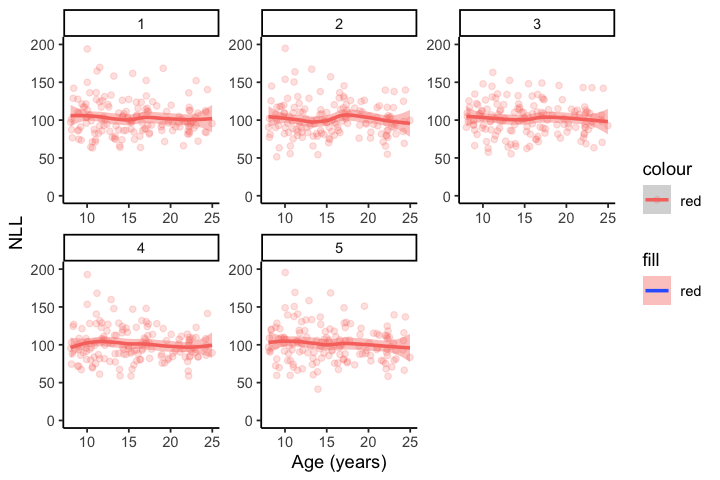

In [66]:
NLL <- NLL[!is.na(NLL$fold), ]
options(repr.plot.width=6, repr.plot.height=4)
P <- ggplot(NLL, aes(x=ExactAge, y=nll, color = "red")) + 
  geom_point(alpha = 0.2)+
  xlab("Age (years)") +
  ylab("NLL") +
  geom_smooth(method=loess, se = TRUE, aes(fill = "red")) +
facet_wrap(~ fold, scales='free') +
  theme_classic() +
    theme(axis.line=element_line()) + 
    scale_x_continuous(limits=c(8,25)) + scale_y_continuous(limits=c(0,200)) 
P

In [67]:
res2 <-cor.test(NLL$nll, NLL$ExactAge,  method = "spearman")
res2

Warning message in cor.test.default(NLL$nll, NLL$ExactAge, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  NLL$nll and NLL$ExactAge
S = 86263000, p-value = 0.05008
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.06995495 


In [186]:
head(df_rt2)
df_rt2 <- df_rt[!(df_rt$RT < 0),]
aggregate(df_rt2[, c('RT', 'ExactAge')], list(df_rt2$StudyID), mean)


StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBins,User,GameNr,Category,Level,MoveNr,RT,Result,ageGroup,f_ageGroup
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,0,2,12,1,2.197,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,0,2,12,2,1.247,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,0,2,12,3,1.062,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,0,2,12,4,0.866,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,1,3,22,1,2.551,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,1,3,22,2,4.436,win,3,3


Group.1,RT,ExactAge
101,1.520286,17.4904
102,2.722740,15.0055
107,3.079647,12.7260
117,1.803640,15.9315
121,2.043000,14.4055
129,2.001449,14.2712
137,3.770086,11.0849
139,1.902011,10.0219
149,2.195737,11.7616
150,1.667912,11.7589


# Model fit stability
## is there a relation between age and nll in any of the folds?

In [68]:
setwd("/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Analysis notebooks/data")
df_fit1 <- read.csv('paramsMatrixRepeat.csv', header=TRUE)
df_fit2 <- read.csv('paramsMatrixRepeat2.csv', header=TRUE)

head(df_fit1)


X,subject,fold,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,101:R_31SM3mwQvAhBwar,1,8.4623,0.0010226,0.41862,0.050000,0.32047,1.9040,1.63420,0.86914,9.7910,10.0000
1,101:R_31SM3mwQvAhBwar,2,10.0000,0.0014914,0.52124,0.050000,0.69611,2.2852,1.16460,-0.51880,9.9548,9.4189
2,101:R_31SM3mwQvAhBwar,3,9.9555,0.0010716,0.44696,0.050146,1.15080,2.1910,1.59740,-0.33365,7.6202,9.6281
3,101:R_31SM3mwQvAhBwar,4,9.8418,0.0010000,0.44760,0.050000,0.87344,1.7751,1.09500,-0.65591,6.5770,9.0735
4,101:R_31SM3mwQvAhBwar,5,8.8168,0.0010068,0.41125,0.050395,0.25006,1.6626,0.70068,0.29663,8.8062,-8.4875
5,102:R_vdABJ1XvXNriwff,1,1.7767,0.0011454,0.38862,0.052138,0.69064,0.2517,1.33210,0.92464,4.9692,9.1711


In [69]:

meanMetrics <- read.csv('meanMetrics.csv', header=TRUE)
head(meanMetrics)
meanMetrics$s_planningDepth <- scale(meanMetrics$planningDepth)
meanMetrics$s_featureDropRate <- scale(meanMetrics$featureDropRate)
meanMetrics$s_heuristicQuality <- scale(meanMetrics$heuristicQuality)

Elo_model <- lm(elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality, data=meanMetrics)
summary(Elo_model)
tab_model(Elo_model)

fold,planningDepth,featureDropRate,heuristicQuality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue
3,6.133230,0.3370140,0.4315325,227,17.4904,17,1,15
3,7.249400,0.3057720,0.6246183,179,15.0055,15,1,15
3,1.835382,0.3623840,0.4482810,179,12.7260,12,0,10
3,3.590356,0.1968608,0.4794924,109,15.9315,15,1,15
3,5.059394,0.2312880,0.5969120,-9,14.4055,14,1,15
3,3.963848,0.2560160,0.5818686,129,14.2712,14,1,15



Call:
lm(formula = elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality, 
    data = meanMetrics)

Residuals:
    Min      1Q  Median      3Q     Max 
-451.20  -73.24    6.56   70.36  260.40 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          91.624      9.096  10.073  < 2e-16 ***
s_planningDepth      20.859      9.728   2.144   0.0336 *  
s_featureDropRate   -25.534      9.978  -2.559   0.0115 *  
s_heuristicQuality   82.074      9.626   8.527 1.36e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 114 on 153 degrees of freedom
Multiple R-squared:  0.3283,	Adjusted R-squared:  0.3152 
F-statistic: 24.93 on 3 and 153 DF,  p-value: 3.445e-13


## Is the correlation between parameters re-fitted on the same held-in data and validated on the same held-out data comparable to Bas' paper?

In [70]:
# function to create correlation dataframes
df_create_corrplot <- function(correlation) {
    parameter <- c("Pruning", "Stopping", "FeatureDrop", "Lapse", "C", "w center", "w twoCon", "w twoUncon", "w threeCon", "w fourCon")
    df <- data.frame(correlation, parameter)
    df$parameter <- factor(df$parameter,levels = c("w fourCon", "w threeCon", "w twoUncon", "w twoCon", "w center", "C",  "Lapse", "FeatureDrop", "Stopping", "Pruning"))
    return(df)
}

# Copy correlation coefficients from python notebook into a vector
allsubjlist <- c(0.686865460589559,
0.739055067322422,
0.7889375399252042,
0.44372019176501964,
0.8112615434231172,
0.9196906455634183,
0.7106035140381669,
0.7476882143898188,
0.5276608016670905,
0.4806622467269085)

childlist <- c(0.691991341991342,
0.8205627705627706,
0.841053391053391,
0.5522366522366522,
0.8575757575757575,
0.8306637806637807,
0.6478354978354979,
0.5873737373737373,
0.5886724386724387,
0.6115440115440115)

adollist <- c( 0.6171040723981901,
0.6556561085972851,
0.7272398190045248,
0.3997285067873303,
0.7265158371040724,
0.949683257918552,
0.6952941176470588,
0.6939366515837104,
0.5219004524886878,
0.44687782805429865)

adultlist <- c(0.7587330316742081,
0.6594570135746607,
0.7649773755656109,
0.2573755656108597,
0.7639819004524887,
0.986606334841629,
0.8187330316742082,
0.9260633484162896,
0.4884162895927602,
0.3909502262443439)

# create correlation df across age
df <- df_create_corrplot(allsubjlist)

# create correlation df children
df_children <- df_create_corrplot(childlist)

# create correlation df adolescents
df_adol <- df_create_corrplot(adollist)

# create correlation df adults
df_adult <- df_create_corrplot(adultlist)


In [117]:
# create function to make correlation plots
corrplot <- function(dataframe, color) {
   # options(repr.plot.width=3.2, repr.plot.height=2)
    p <- ggplot(data=dataframe, aes(y=parameter, x=correlation)) +
    geom_bar(stat="identity", fill = color) +
    labs(x = "Correlation", y = "Parameter") +
    theme(panel.background = element_rect(fill = "white", colour = "white", size = 0.5, linetype = "solid"),
          axis.title = element_text(size = 12), axis.line = element_line(colour = "black"), text = element_text(family = "Arial", size=12,colour="#262626")) +
    scale_x_continuous(limits=c(0, 1), breaks=seq(0,1,0.2)) 
    return(p)
}

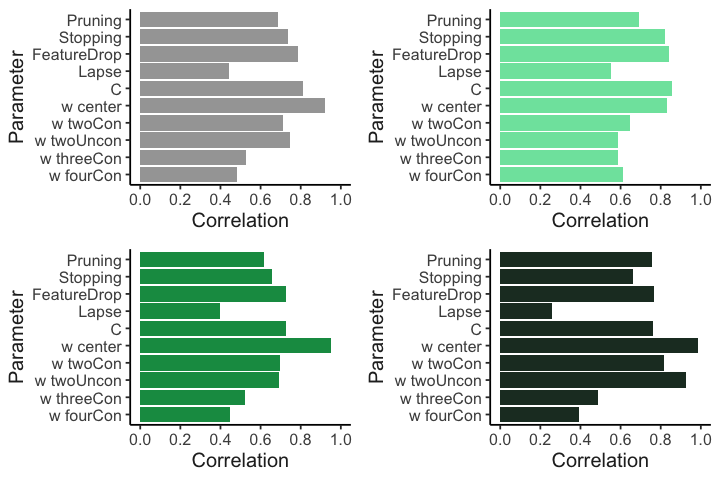

In [162]:
# create correlation plots

options(repr.plot.width=6, repr.plot.height =4)
require(gridExtra)
p1 <- corrplot(df, "#a5a5a5")
p2 <- corrplot(df_children, "#7DE3AC")
p3 <- corrplot(df_adol, "#129951")
p4 <- corrplot(df_adult, "#20382B")

grid.arrange(p1, p2, p3, p4, ncol=2, nrow = 2)

In [163]:
#Save the figure above to Pdf
pdf("refitcorrelations.pdf", width = 6, height = 4) # Open a new pdf file
grid.arrange(p1, p2, p3, p4, ncol=2, nrow = 2) # Write the grid.arrange in the file
dev.off() # Close the file
#graph <- grid.arrange(p1, p2, p3, p4, ncol=2, nrow = 2) #also tried this way but rendering did not look as nice in overleaf
#ggsave(graph, filename = "graphtest.pdf", device = cairo_pdf, width = 6, height = 4)


quartz_off_screen 
                2

# Individual differences: FOS and BIS-11

In [120]:
setwd("/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Analysis notebooks/data")
fos <- read.csv('fos_only.csv', header=TRUE)
bis <- read.csv('Bis_only.csv', header=TRUE)
Metrics <- read.csv('Metrics.csv', header=TRUE)
fos_bis <- merge(fos, bis, by="StudyID")
meanMetrics2 <- aggregate(Metrics[, 2:6], list(Metrics$StudyID), mean)
meanMetrics2$StudyID <- meanMetrics2$Group.1
fos_bis2 <- merge(fos_bis, meanMetrics2, by="StudyID")

StudyID,fos_total,ExactAge,bis_total,Group.1,fold,planningDepth,featureDropRate,heuristicQuality,elo,s_ExactAge,s_fos_total,s_bis_total
101,41,17.4904,15,101,3,6.133230,0.3370140,0.4315325,227,0.31791200,0.01799115,-0.3805117
102,41,15.0055,16,102,3,7.249400,0.3057720,0.6246183,179,-0.17030808,0.01799115,-0.1212985
107,44,12.7260,18,107,3,1.835382,0.3623840,0.4482810,179,-0.61817225,0.61940956,0.3971279
117,33,15.9315,23,117,3,3.590356,0.1968608,0.4794924,109,0.01162753,-1.58579129,1.6931940
121,49,14.4055,14,121,3,5.059394,0.2312880,0.5969120,-9,-0.28819293,1.62177358,-0.6397249
129,38,14.2712,19,129,3,3.963848,0.2560160,0.5818686,129,-0.31457948,-0.58342726,0.6563412


`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


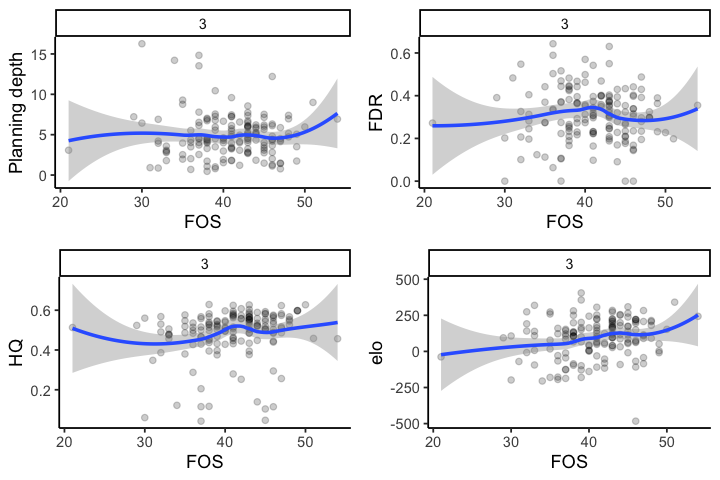

In [138]:
head(fos_bis2)
options(repr.plot.width=6, repr.plot.height=4)
pd <- ggplot(fos_bis2, aes(x=fos_total, y=planningDepth)) + 
  geom_point(alpha = 0.2)+
  xlab("FOS") +
  ylab("Planning depth") +
  geom_smooth(method=loess, se = TRUE) +
facet_wrap(~ fold, scales='free') +
  theme_classic()

options(repr.plot.width=6, repr.plot.height=4)
fdr <- ggplot(fos_bis2, aes(x=fos_total, y=featureDropRate)) + 
  geom_point(alpha = 0.2)+
  xlab("FOS") +
  ylab("FDR") +
  geom_smooth(method=loess, se = TRUE) +
facet_wrap(~ fold, scales='free') +
  theme_classic()  

options(repr.plot.width=6, repr.plot.height=4)
hq <- ggplot(fos_bis2, aes(x=fos_total, y=heuristicQuality)) + 
  geom_point(alpha = 0.2)+
  xlab("FOS") +
  ylab("HQ") +
  geom_smooth(method=loess, se = TRUE) +
facet_wrap(~ fold, scales='free') +
  theme_classic() 

options(repr.plot.width=6, repr.plot.height=4)
elo <- ggplot(fos_bis2, aes(x=fos_total, y=elo)) + 
  geom_point(alpha = 0.2)+
  xlab("FOS") +
  ylab("elo") +
  geom_smooth(method=loess, se = TRUE) +
facet_wrap(~ fold, scales='free') +
  theme_classic() 

grid.arrange(pd, fdr, hq, elo, ncol=2)

In [139]:
# is PD predicted by the FOS and BIS?
fos_bis2$s_ExactAge <- scale(fos_bis2$ExactAge)
fos_bis2$s_fos_total <- scale(fos_bis2$fos_total)
fos_bis2$s_bis_total <- scale(fos_bis2$bis_total)

PD_Model <- lm(planningDepth ~ s_fos_total + s_bis_total + s_ExactAge, data=fos_bis2)
summary(PD_Model)# show results
tab_model(PD_Model)


Call:
lm(formula = planningDepth ~ s_fos_total + s_bis_total + s_ExactAge, 
    data = fos_bis2)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9452 -1.6528 -0.3588  1.2358 10.7075 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.86006    0.21166  22.962  < 2e-16 ***
s_fos_total -0.30119    0.24637  -1.222  0.22342    
s_bis_total -0.04913    0.23905  -0.206  0.83746    
s_ExactAge   0.61962    0.22149   2.798  0.00582 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.644 on 152 degrees of freedom
Multiple R-squared:  0.05082,	Adjusted R-squared:  0.03209 
F-statistic: 2.713 on 3 and 152 DF,  p-value: 0.04697


In [123]:
# is HQ predicted by the FOS and BIS?
fos_bis2$s_ExactAge <- scale(fos_bis2$ExactAge)
fos_bis2$s_fos_total <- scale(fos_bis2$fos_total)
fos_bis2$s_bis_total <- scale(fos_bis2$bis_total)

PD_Model <- lm(heuristicQuality ~ s_fos_total + s_bis_total + s_ExactAge, data=fos_bis2)
summary(PD_Model)# show results
tab_model(PD_Model)


Call:
lm(formula = heuristicQuality ~ s_fos_total + s_bis_total + s_ExactAge, 
    data = fos_bis2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.45748 -0.03047  0.02616  0.07040  0.15687 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.484535   0.009326  51.955  < 2e-16 ***
s_fos_total  0.006680   0.010856   0.615  0.53925    
s_bis_total -0.008104   0.010533  -0.769  0.44284    
s_ExactAge   0.037073   0.009759   3.799  0.00021 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1165 on 152 degrees of freedom
Multiple R-squared:  0.1172,	Adjusted R-squared:  0.09976 
F-statistic: 6.725 on 3 and 152 DF,  p-value: 0.0002726


In [130]:
# is ELO predicted by the FOS and BIS?
fos_bis2$s_ExactAge <- scale(fos_bis2$ExactAge)
fos_bis2$s_fos_total <- scale(fos_bis2$fos_total)
fos_bis2$s_bis_total <- scale(fos_bis2$bis_total)

Elo_Model <- lm(elo ~ s_fos_total + s_bis_total + s_ExactAge, data=fos_bis2)
summary(Elo_Model)# show results
tab_model(Elo_Model)


Call:
lm(formula = elo ~ s_fos_total + s_bis_total + s_ExactAge, data = fos_bis2)

Residuals:
    Min      1Q  Median      3Q     Max 
-558.09  -77.21   16.96   85.03  290.56 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 92.60897   10.23488   9.048 6.47e-16 ***
s_fos_total 15.73662   11.91369   1.321    0.189    
s_bis_total -0.06768   11.55961  -0.006    0.995    
s_ExactAge  47.34445   10.71031   4.420 1.86e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 127.8 on 152 degrees of freedom
Multiple R-squared:  0.1538,	Adjusted R-squared:  0.1371 
F-statistic: 9.211 on 3 and 152 DF,  p-value: 1.23e-05


In [131]:
# is Feature drop predicted by the FOS and BIS?
fos_bis2$s_ExactAge <- scale(fos_bis2$ExactAge)
fos_bis2$s_fos_total <- scale(fos_bis2$fos_total)
fos_bis2$s_bis_total <- scale(fos_bis2$bis_total)

fdr_Model <- lm(featureDropRate ~ s_fos_total + s_bis_total + s_ExactAge, data=fos_bis2)
summary(fdr_Model)# show results
tab_model(fdr_Model)


Call:
lm(formula = featureDropRate ~ s_fos_total + s_bis_total + s_ExactAge, 
    data = fos_bis2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.32074 -0.07931  0.00313  0.07973  0.32182 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.311356   0.009982  31.192   <2e-16 ***
s_fos_total -0.005745   0.011619  -0.494    0.622    
s_bis_total -0.001944   0.011274  -0.172    0.863    
s_ExactAge   0.005053   0.010446   0.484    0.629    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1247 on 152 degrees of freedom
Multiple R-squared:  0.002526,	Adjusted R-squared:  -0.01716 
F-statistic: 0.1283 on 3 and 152 DF,  p-value: 0.9432


In [124]:
corr <- cor.test(x=fos_bis2$fos_total, y=fos_bis2$heuristicQuality, method = 'spearman')
corr

Warning message in cor.test.default(x = fos_bis2$fos_total, y = fos_bis2$heuristicQuality, :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  fos_bis2$fos_total and fos_bis2$heuristicQuality
S = 468340, p-value = 0.001056
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2597882 


# check outlier planning depth

In [142]:
head(Metrics)

subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
101:R_31SM3mwQvAhBwar,1,6.67758,0.37914,0.4459566,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
101:R_31SM3mwQvAhBwar,2,5.17404,0.40756,0.4295637,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
101:R_31SM3mwQvAhBwar,3,6.41074,0.20175,0.4282075,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
101:R_31SM3mwQvAhBwar,4,6.03305,0.25907,0.4370336,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
101:R_31SM3mwQvAhBwar,5,6.37074,0.43755,0.4169013,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
102:R_vdABJ1XvXNriwff,1,9.34128,0.13684,0.6275961,179,102,11/12/05,F,15.0055,15,11/10/20,"(12, 17]",1,15


In [159]:
meanMetrics2 %>%
    top_n(20, planningDepth)

Metrics %>%
    top_n(3, planningDepth)

Group.1,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID
102,3,7.249400,3.057720e-01,0.62461834,179,102
209,3,8.559386,5.499340e-01,0.43413134,95,209
236,3,12.206460,3.855800e-05,0.11452235,-483,236
372,3,16.263678,7.357261e-05,0.05989027,-198,372
423,3,14.832268,2.968112e-04,0.04221531,-187,423
436,3,13.529514,1.071960e-01,0.11510780,-127,436
449,3,7.456060,1.643024e-01,0.59471142,222,449
560,3,7.560000,4.422660e-01,0.37549744,151,560
844,3,14.212606,1.238200e-01,0.12181901,-205,844
883,3,7.269388,3.651320e-01,0.54644974,-99,883


subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
236:R_24qFUPTZKx0SybQ,5,19.7640,1.00e-04,0.08422408,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
372:R_Pwksr0eXcbCEd8d,5,20.1273,1.75e-05,-0.00489010,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
436:R_UYNV3EWWRV3lLoZ,4,19.9704,0.00e+00,-0.10391390,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10


In [160]:
filter(Metrics, StudyID ==236)
filter(Metrics, StudyID ==372)
filter(Metrics, StudyID ==436)

subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
236:R_24qFUPTZKx0SybQ,1,10.4260,8.19e-06,0.24035929,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
236:R_24qFUPTZKx0SybQ,2,0.0000,4.57e-05,0.13216281,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
236:R_24qFUPTZKx0SybQ,3,18.3042,2.29e-05,0.03867513,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
236:R_24qFUPTZKx0SybQ,4,12.5381,1.60e-05,0.07719043,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
236:R_24qFUPTZKx0SybQ,5,19.7640,1.00e-04,0.08422408,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10


subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
372:R_Pwksr0eXcbCEd8d,1,17.91720,7.9100e-05,0.05874636,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
372:R_Pwksr0eXcbCEd8d,2,17.29430,3.0400e-09,0.14878392,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
372:R_Pwksr0eXcbCEd8d,3,8.55339,1.0796e-04,0.13890093,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
372:R_Pwksr0eXcbCEd8d,4,17.42620,1.6330e-04,-0.04208978,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
372:R_Pwksr0eXcbCEd8d,5,20.12730,1.7500e-05,-0.00489010,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15


subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
436:R_UYNV3EWWRV3lLoZ,1,19.54250,0.00078665,-0.000333426,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
436:R_UYNV3EWWRV3lLoZ,2,2.92421,0.53481000,0.385297557,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
436:R_UYNV3EWWRV3lLoZ,3,9.31366,0.00000641,0.227763972,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
436:R_UYNV3EWWRV3lLoZ,4,19.97040,0.00000000,-0.103913895,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
436:R_UYNV3EWWRV3lLoZ,5,15.89680,0.00037703,0.066724769,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
